In [1]:
'''
    In this file, we conduct the NN with the classification problem. So, we tried to build NN without techiques at first, with L2, and with dropout respectively.
'''
# Import everything we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
# Step 1: Import package,  Dataset uploading and preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(1)


data = pd.read_csv("./Resources/2024_ionosphere_data.csv", header=None)
data.iloc[:, 34] = data.iloc[:, 34].replace({'g': 1, 'b': 0})

# shuffling data
shuffled_data = data.sample(frac=1).astype(float)

# dividing data into training and test samples
train_data = shuffled_data.iloc[:int(0.8 * len(data))]
test_data = shuffled_data.iloc[int(0.8 * len(data)):]

pd.set_option('future.no_silent_downcasting', True)

# highlighting features and target variable
X_train = train_data.drop(train_data.columns[34], axis=1).values
Y_train = train_data[train_data.columns[34]].values.reshape(-1,1)
X_test = test_data.drop(train_data.columns[34], axis=1).values
Y_test = test_data[train_data.columns[34]].values.reshape(-1,1)
# Verify shapes and data types
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

print(type(Y_train))
print(type(X_train))
print(X_train.dtype)
print(Y_train.dtype)

Training set shape: (280, 34) (280, 1)
Testing set shape: (71, 34) (71, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
float64
float64


In [154]:
# Network Architecture
layer_dims = [34, 4, 1]
epoches = 10000
learning_rate = 0.005
# seed = 5
lambda_val = 0.045

In [152]:
# Step 2 (Solution 1): Define necessary functions - Basic
def initialize_weights(layer_dims, seed=None):
    weights = {}
    biases = {}

    # Setup seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Loop through the layers and initialize weights and biases using Xavier Initialization
    for i in range(1, len(layer_dims)):  # Start from layer 1 to layer_dims-1
        # Xavier initialization for weights
        weights[f"W{i}"] = np.random.randn(layer_dims[i-1], layer_dims[i]).astype(np.float64) * np.sqrt(1 / layer_dims[i-1])
        biases[f"b{i}"] = np.zeros((1, layer_dims[i]), dtype=np.float64)

    return weights, biases


def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip to prevent log(0)

    # Standard binary cross-entropy loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return loss


# Sigmoid activation function
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Clip to avoid overflow errors
    return 1 / (1 + np.exp(-x))


# Sigmoid derivative (used in backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)  # Derivative of sigmoid

# Tanh activation function
def tanh(x):
    return np.tanh(x)

# Tanh derivative (used in backpropagation)
def tanh_derivative(x):
    return 1.0 - np.tanh(x) ** 2

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# ReLU derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def forward_propagation(X, weights, biases):
    Xi = X  # Input layer
    Z = {}
    A = {}
    L = len(
        weights
    )  # Number of layers / Just 3 weights inside --> So we need plus one for layers

    for index in range(1, L + 1):  # Loop over layers from 1 to L
        W = weights[f"W{index}"]
        b = biases[f"b{index}"]
        Zi = np.dot(Xi, W) + b
        Z[f"Z{index}"] = Zi

        # Apply Sigmoid activation for the last layer, ReLU for hidden layers
        if index == L:
            Ai = sigmoid(Zi)
        else:
            Ai = tanh(Zi)
        A[f"A{index}"] = Ai
        Xi = Ai  # Output of current layer becomes input to the next layer

    return Z, A


def backward_propagation(
    X, Y, Z, A, weights, output_activation="sigmoid", hidden_activation="tanh"
):
    m = X.shape[0]  # Number of examples
    gradients = {}
    L = len(weights)  # Number of layers with weights
    # Step 1: Initialize the derivative for the output layer
    A_last = A[f"A{L}"]  # The predicted output from the last layer

    if output_activation == "sigmoid":
        dA_last = A_last - Y  # Error at the output layer for sigmoid
    else:
        raise NotImplementedError(
            "Currently supports sigmoid for the output layer only."
        )

    dA_next = dA_last

    # Step 2: Backpropagation through layers (from L to 1)
    for l in reversed(range(1, L + 1)):
        if l == L:  # For the output layer, use dA_last directly
            dZ = dA_last
        else:
            # For hidden layers, backpropagate the error
            if hidden_activation == "relu":
                # Ensure proper reshaping of dA_next and weights for matrix multiplication
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * relu_derivative(
                    Z[f"Z{l}"]
                )  # Apply derivative of activation
            elif hidden_activation == "sigmoid":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * sigmoid_derivative(
                    A[f"A{l}"]
                )  # Apply derivative of sigmoid
            elif hidden_activation == "tanh":  # New condition for tanh activation
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * tanh_derivative(
                    Z[f"Z{l}"]
                )  # Apply derivative of Tanh activation
            else:
                raise NotImplementedError(
                    f"Unsupported activation function: {hidden_activation}"
                )

        # Compute gradients for weights and biases
        A_prev = (
            A[f"A{l-1}"] if l > 1 else X
        )  # A_prev is the activation from the previous layer or input X
        gradients[f"dW{l}"] = np.dot(A_prev.T, dZ) / m  # Gradient of W
        gradients[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m  # Gradient of b

        # Store dA_next for the next iteration
        dA_next = dZ

    return gradients

# To visualize the results
def pca_reduce_to_2d(features):
    # Step 1: Center the data by subtracting the mean
    mean = np.mean(features, axis=0)
    centered_data = features - mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)  # Covariance matrix of the centered data

    # Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Sort eigenvectors by eigenvalues in descending order (top 2 eigenvectors)
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Get indices of the sorted eigenvalues
    top_2_eigenvectors = eigenvectors[:, sorted_indices[:2]]  # Select the top 2 eigenvectors

    # Step 5: Project the centered data onto the top 2 eigenvectors (PCA components)
    reduced_features = np.dot(centered_data, top_2_eigenvectors)

    return reduced_features

def visualize_learning_curve(train_losses, test_losses):
    # Visualize the learning curves for both train and test data together
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Learning Curves - Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()  # Show legend to differentiate between train and test curves
    plt.grid(True)
    plt.show()

def visualize_2d_latent_space(ax, features, y, title):
    # Step 1: Reduce dimensions using custom PCA
    reduced_features = pca_reduce_to_2d(features)  # Reducing to 2 dimensions

    # Step 2: Plot the reduced features in the given axis
    ax.scatter(reduced_features[y.reshape(-1) == 0][:, 0], reduced_features[y.reshape(-1) == 0][:, 1], color='blue', label='Class 1')
    ax.scatter(reduced_features[y.reshape(-1) == 1][:, 0], reduced_features[y.reshape(-1) == 1][:, 1], color='red', label='Class 2')

    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()
    ax.grid(True)

def visualie_latent_features(latent_features, step, hidden_dim, y_train):
    # After training, reduce latent features to 2D for each epoch checkpoint and visualize
    num_plots = len(latent_features)
    
    # Create subplots in a single row
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))  # Adjust size as needed
    fig.tight_layout(pad=4.0)  # Add some padding between plots

    for i, latent in enumerate(latent_features):
        if latent is not None:
            # Visualize each set of latent features
            visualize_2d_latent_space(axs[i], latent, y_train, f"{i * step} EPOCHS - 2D VISUALIZATION - {hidden_dim} NEURONS")

    plt.show()

def plot_actual_vs_predicted(actual, predicted, title="Actual vs Predicted"):
    # visualize the predict model against actual values (test data)
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label="Predicted", linestyle='-', marker='o')
    plt.plot(actual, label="Actual", linestyle='-', marker='.')
    plt.title("Model Predictions vs Actual Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def thresholds(data):
    data = np.where(data < 0.5, 0, 1)
    return data

def update_parameters(weights, biases, gradients, learning_rate):
    L = len(weights)  # Number of layers

    # Update each layer's weights and biases without L2 regularization
    for l in range(1, L + 1):
        weights[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
        biases[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    return weights, biases


def save_parameters(weights, biases, index):
    file_path = "./Parameters"
    np.save(f"{file_path}/weights_{index}.npy", weights)
    np.save(f"{file_path}/biases_{index}.npy", biases)

def train(
        X, 
        Y, 
        layer_dims, 
        epoches, 
        learning_rate, 
        X_test, 
        Y_test, 
        seed = None
    ):
    weights = {}
    biases = {}
    train_losses = []
    test_losses = []
    latent_features = []
    step = int(epoches / 2) # Gather just two stages
    
    # Initialize weights and biases
    weights, biases = initialize_weights(layer_dims, seed)
    save_parameters(weights, biases, "initialize")
    
    # Number of layers
    L = len(layer_dims)

    # Training loop
    for i in range(epoches):
        # Forward propagation with dropout
        Z, A = forward_propagation(X, weights, biases)
        
        # Gather the latent features
        if i % step == 0:
            latent_features.append(
                A[f"A{L-2}"]
            )
        
        # Calculate training loss with L2 regularization
        train_loss = binary_cross_entropy_loss(Y, A[f"A{len(layer_dims) - 1}"])
        train_losses.append(train_loss)
        
        # Backward propagation with dropout masks
        gradients = backward_propagation(X, Y, Z, A, weights, "sigmoid", "tanh")
        
        # Update parameters with L2 regularization
        weights, biases = update_parameters(weights, biases, gradients, learning_rate)
        
        # Test set forward propagation (without dropout)
        _, A_test = forward_propagation(X_test, weights, biases)
        
        # Calculate test loss with L2 regularization
        test_loss = binary_cross_entropy_loss(Y_test, A_test[f"A{len(layer_dims) - 1}"])
        test_losses.append(test_loss)

        # Print epoch tracking every 500 epochs
        if i % 500 == 0:
            print(f"Epoch {i+1}/{epoches}, Train Loss: {train_loss}, Test Loss: {test_loss}")

    return weights, biases, latent_features, train_losses, test_losses



Epoch 1/10000, Train Loss: 0.661841459812336, Test Loss: 0.6172983613581547
Epoch 501/10000, Train Loss: 0.524559106482768, Test Loss: 0.4978179362268643
Epoch 1001/10000, Train Loss: 0.4568503667691533, Test Loss: 0.4534419582649293
Epoch 1501/10000, Train Loss: 0.40557374885538333, Test Loss: 0.42494103378022
Epoch 2001/10000, Train Loss: 0.3625885788525138, Test Loss: 0.4074014495486847
Epoch 2501/10000, Train Loss: 0.3262553742482582, Test Loss: 0.39899697259928796
Epoch 3001/10000, Train Loss: 0.29656869945069864, Test Loss: 0.39672027514915487
Epoch 3501/10000, Train Loss: 0.2733077828675626, Test Loss: 0.3972167711846649
Epoch 4001/10000, Train Loss: 0.255249817125043, Test Loss: 0.3985799098228514
Epoch 4501/10000, Train Loss: 0.24090706742260296, Test Loss: 0.39989167944030335
Epoch 5001/10000, Train Loss: 0.22906990141957978, Test Loss: 0.40080748428907775
Epoch 5501/10000, Train Loss: 0.21894510008429535, Test Loss: 0.4012805108970126
Epoch 6001/10000, Train Loss: 0.21004114

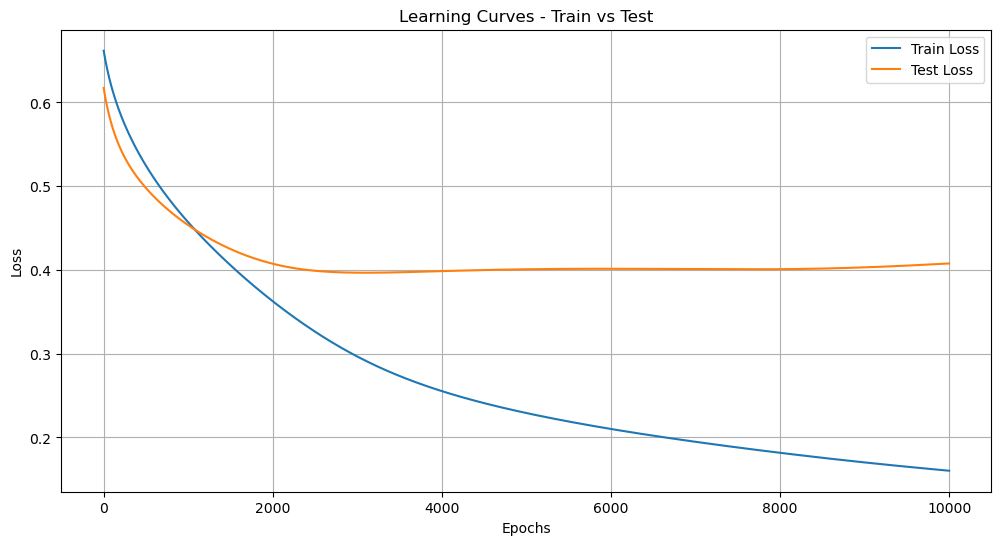

BCE loss for Train Data: 0.16017736274738967
BCE loss for Test Data: 0.4077547613350767


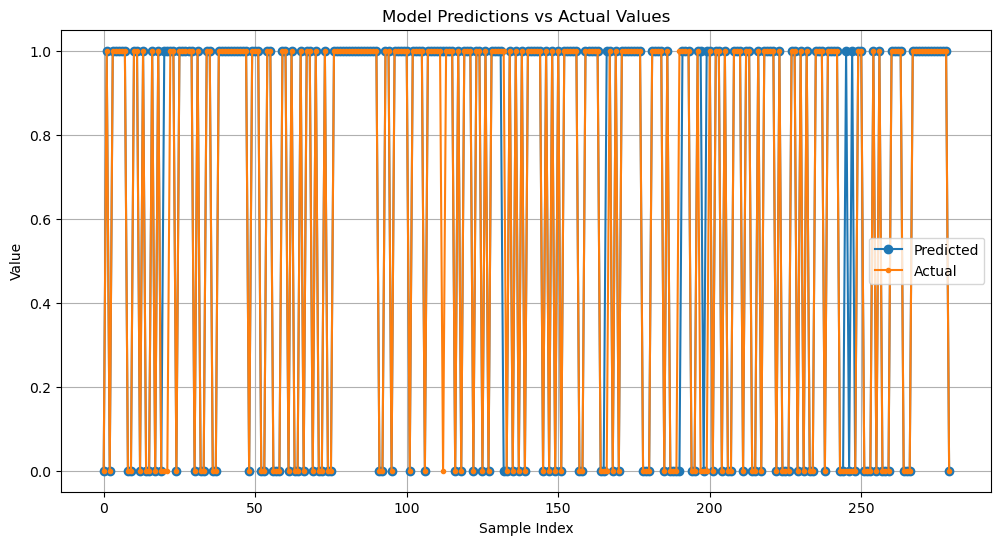

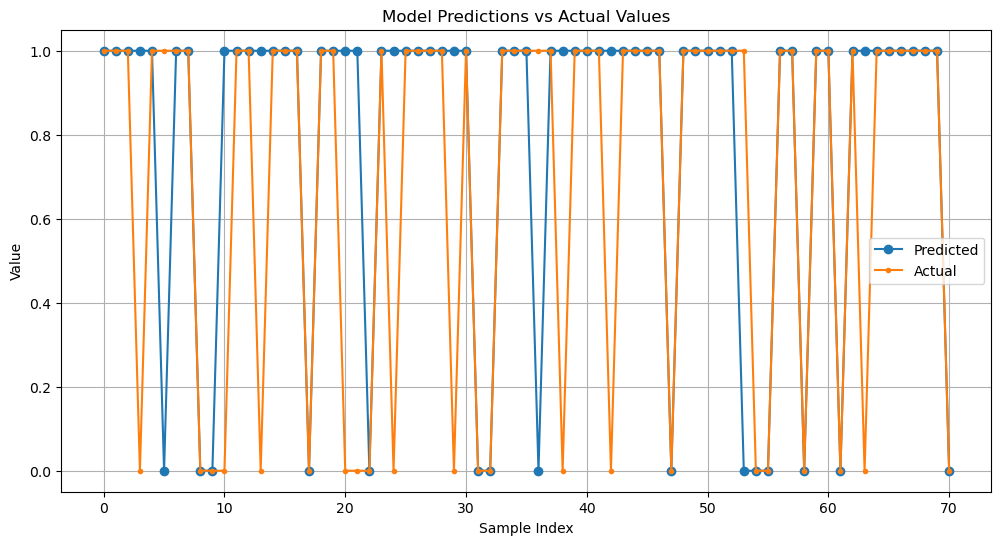

In [155]:
# Step 3 (Solution 1): Training model, Learning curve, and Train / Test Loss (BCE)

# Network Architecture
index_run = "Solution_1"
# Number of layers
L = len(layer_dims)

# Training model
weights, biases, latent_features, train_losses, test_losses = train(
    X_train, 
    Y_train, 
    layer_dims, 
    epoches, 
    learning_rate, 
    X_test, 
    Y_test, 
    seed=seed
)
save_parameters(weights, biases, index_run)

visualize_learning_curve(
    train_losses,
    test_losses
)

_, A_train = forward_propagation(X_train, weights, biases)
_, A_test = forward_propagation(X_test, weights, biases)

Y_pred_train = A_train[f"A{L-1}"]
Y_pred_test = A_test[f"A{L-1}"]

bce_train = binary_cross_entropy_loss(Y_train, Y_pred_train)
bce_test = binary_cross_entropy_loss(Y_test, Y_pred_test)

print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

plot_actual_vs_predicted(Y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(Y_test, thresholds(Y_pred_test))


In [156]:
# Step 2 (Solution 2): Define necessary functions - L2 
def initialize_weights(layer_dims, seed=None):
    weights = {}
    biases = {}

    # Setup seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Loop through the layers and initialize weights and biases using Xavier Initialization
    for i in range(1, len(layer_dims)):  # Start from layer 1 to layer_dims-1
        # Xavier initialization for weights
        weights[f"W{i}"] = np.random.randn(layer_dims[i-1], layer_dims[i]).astype(np.float64) * np.sqrt(1 / layer_dims[i-1])
        biases[f"b{i}"] = np.zeros((1, layer_dims[i]), dtype=np.float64)

    return weights, biases


def binary_cross_entropy_loss(y_true, y_pred, weights, lambda_val):
    epsilon = 1e-12  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip to prevent log(0)

    cross_entropy_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Applied
    l2 = (lambda_val / (2 * y_true.shape[0])) * sum([np.sum(np.square(W)) for W in weights.values()])

    # Standard binary cross-entropy loss
    loss = cross_entropy_loss + l2

    return loss


# Sigmoid activation function
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Clip to avoid overflow errors
    return 1 / (1 + np.exp(-x))


# Sigmoid derivative (used in backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)  # Derivative of sigmoid

# Tanh activation function
def tanh(x):
    return np.tanh(x)

# Tanh derivative (used in backpropagation)
def tanh_derivative(x):
    return 1.0 - np.tanh(x) ** 2

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# ReLU derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def forward_propagation(X, weights, biases):
    Xi = X  # Input layer
    Z = {}
    A = {}
    L = len(
        weights
    )  # Number of layers / Just 3 weights inside --> So we need plus one for layers

    for index in range(1, L + 1):  # Loop over layers from 1 to L
        W = weights[f"W{index}"]
        b = biases[f"b{index}"]
        Zi = np.dot(Xi, W) + b
        Z[f"Z{index}"] = Zi

        # Apply Sigmoid activation for the last layer, ReLU for hidden layers
        if index == L:
            Ai = sigmoid(Zi)
        else:
            Ai = tanh(Zi)
        A[f"A{index}"] = Ai
        Xi = Ai  # Output of current layer becomes input to the next layer

    return Z, A


def backward_propagation(
    X, Y, Z, A, weights, output_activation="sigmoid", hidden_activation="tanh"
):
    m = X.shape[0]  # Number of examples
    gradients = {}
    L = len(weights)  # Number of layers with weights
    # Step 1: Initialize the derivative for the output layer
    A_last = A[f"A{L}"]  # The predicted output from the last layer

    if output_activation == "sigmoid":
        dA_last = A_last - Y  # Error at the output layer for sigmoid
    else:
        raise NotImplementedError(
            "Currently supports sigmoid for the output layer only."
        )

    dA_next = dA_last

    # Step 2: Backpropagation through layers (from L to 1)
    for l in reversed(range(1, L + 1)):
        if l == L:  # For the output layer, use dA_last directly
            dZ = dA_last
        else:
            # For hidden layers, backpropagate the error
            if hidden_activation == "relu":
                # Ensure proper reshaping of dA_next and weights for matrix multiplication
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * relu_derivative(
                    Z[f"Z{l}"]
                )  # Apply derivative of activation
            elif hidden_activation == "sigmoid":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * sigmoid_derivative(
                    A[f"A{l}"]
                )  # Apply derivative of sigmoid
            elif hidden_activation == "tanh":  # New condition for tanh activation
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * tanh_derivative(
                    Z[f"Z{l}"]
                )  # Apply derivative of Tanh activation
            else:
                raise NotImplementedError(
                    f"Unsupported activation function: {hidden_activation}"
                )

        # Compute gradients for weights and biases
        A_prev = (
            A[f"A{l-1}"] if l > 1 else X
        )  # A_prev is the activation from the previous layer or input X
        gradients[f"dW{l}"] = np.dot(A_prev.T, dZ) / m  # Gradient of W
        gradients[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m  # Gradient of b

        # Store dA_next for the next iteration
        dA_next = dZ

    return gradients

# To visualize the results
def pca_reduce_to_2d(features):
    # Step 1: Center the data by subtracting the mean
    mean = np.mean(features, axis=0)
    centered_data = features - mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)  # Covariance matrix of the centered data

    # Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Sort eigenvectors by eigenvalues in descending order (top 2 eigenvectors)
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Get indices of the sorted eigenvalues
    top_2_eigenvectors = eigenvectors[:, sorted_indices[:2]]  # Select the top 2 eigenvectors

    # Step 5: Project the centered data onto the top 2 eigenvectors (PCA components)
    reduced_features = np.dot(centered_data, top_2_eigenvectors)

    return reduced_features

def visualize_learning_curve(train_losses, test_losses):
    # Visualize the learning curves for both train and test data together
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Learning Curves - Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()  # Show legend to differentiate between train and test curves
    plt.grid(True)
    plt.show()

def visualize_2d_latent_space(ax, features, y, title):
    # Step 1: Reduce dimensions using custom PCA
    reduced_features = pca_reduce_to_2d(features)  # Reducing to 2 dimensions

    # Step 2: Plot the reduced features in the given axis
    ax.scatter(reduced_features[y.reshape(-1) == 0][:, 0], reduced_features[y.reshape(-1) == 0][:, 1], color='blue', label='Class 1')
    ax.scatter(reduced_features[y.reshape(-1) == 1][:, 0], reduced_features[y.reshape(-1) == 1][:, 1], color='red', label='Class 2')

    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()
    ax.grid(True)

def visualie_latent_features(latent_features, step, hidden_dim, y_train):
    # After training, reduce latent features to 2D for each epoch checkpoint and visualize
    num_plots = len(latent_features)
    
    # Create subplots in a single row
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))  # Adjust size as needed
    fig.tight_layout(pad=4.0)  # Add some padding between plots

    for i, latent in enumerate(latent_features):
        if latent is not None:
            # Visualize each set of latent features
            visualize_2d_latent_space(axs[i], latent, y_train, f"{i * step} EPOCHS - 2D VISUALIZATION - {hidden_dim} NEURONS")

    plt.show()

def plot_actual_vs_predicted(actual, predicted, title="Actual vs Predicted"):
    # visualize the predict model against actual values (test data)
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label="Predicted", linestyle='-', marker='o')
    plt.plot(actual, label="Actual", linestyle='-', marker='.')
    plt.title("Model Predictions vs Actual Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def thresholds(data):
    data = np.where(data < 0.5, 0, 1)
    return data

def update_parameters(weights, biases, gradients, learning_rate, lambda_val):
    L = len(weights)  # Number of layers

    # Update each layer's weights and biases without L2 regularization
    for l in range(1, L + 1):
        weights[f"W{l}"] -= learning_rate * (gradients[f"dW{l}"] + (lambda_val / weights[f"W{l}"].shape[0]) * weights[f"W{l}"])
        # No for biases
        biases[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    return weights, biases


def save_parameters(weights, biases, index):
    file_path = "./Parameters"
    np.save(f"{file_path}/weights_{index}.npy", weights)
    np.save(f"{file_path}/biases_{index}.npy", biases)

def train(
        X, 
        Y, 
        layer_dims, 
        epoches, 
        learning_rate, 
        X_test, 
        Y_test, 
        seed = None,
        lambda_val = 0.01
    ):
    weights = {}
    biases = {}
    train_losses = []
    test_losses = []
    latent_features = []
    step = int(epoches / 2) # Gather just two stages
    
    # Initialize weights and biases
    weights, biases = initialize_weights(layer_dims, seed)
    save_parameters(weights, biases, "initialize")
    
    # Number of layers
    L = len(layer_dims)

    # Training loop
    for i in range(epoches):
        # Forward propagation with dropout
        Z, A = forward_propagation(X, weights, biases)
        
        # Gather the latent features
        if i % step == 0:
            latent_features.append(
                A[f"A{L-2}"]
            )
        
        # Calculate training loss with L2 regularization
        train_loss = binary_cross_entropy_loss(Y, A[f"A{len(layer_dims) - 1}"], weights, lambda_val)
        train_losses.append(train_loss)
        
        # Backward propagation with dropout masks
        gradients = backward_propagation(X, Y, Z, A, weights, "sigmoid", "tanh")
        
        # Update parameters with L2 regularization
        weights, biases = update_parameters(weights, biases, gradients, learning_rate, lambda_val)
        
        # Test set forward propagation (without dropout)
        _, A_test = forward_propagation(X_test, weights, biases)
        
        # Calculate test loss with L2 regularization
        test_loss = binary_cross_entropy_loss(Y_test, A_test[f"A{len(layer_dims) - 1}"], weights, lambda_val)
        test_losses.append(test_loss)

        # Print epoch tracking every 500 epochs
        if i % 500 == 0:
            print(f"Epoch {i+1}/{epoches}, Train Loss: {train_loss}, Test Loss: {test_loss}")

    return weights, biases, latent_features, train_losses, test_losses

Epoch 1/10000, Train Loss: 0.6623204487831421, Test Loss: 0.619188120349888
Epoch 501/10000, Train Loss: 0.5269469551814815, Test Loss: 0.5021498032733229
Epoch 1001/10000, Train Loss: 0.4631721710101509, Test Loss: 0.46075292482696845
Epoch 1501/10000, Train Loss: 0.41577091438420066, Test Loss: 0.43390082289659193
Epoch 2001/10000, Train Loss: 0.37631024317774053, Test Loss: 0.4162166801844511
Epoch 2501/10000, Train Loss: 0.3427285946671138, Test Loss: 0.40610461906791945
Epoch 3001/10000, Train Loss: 0.3145509137148872, Test Loss: 0.40175523215964143
Epoch 3501/10000, Train Loss: 0.29184015295985294, Test Loss: 0.4005519540829924
Epoch 4001/10000, Train Loss: 0.2739987995854621, Test Loss: 0.40060897084839653
Epoch 4501/10000, Train Loss: 0.25993605571164397, Test Loss: 0.400971025962267
Epoch 5001/10000, Train Loss: 0.24858231484998242, Test Loss: 0.40119797169688465
Epoch 5501/10000, Train Loss: 0.2391265934913837, Test Loss: 0.4011419958445717
Epoch 6001/10000, Train Loss: 0.231

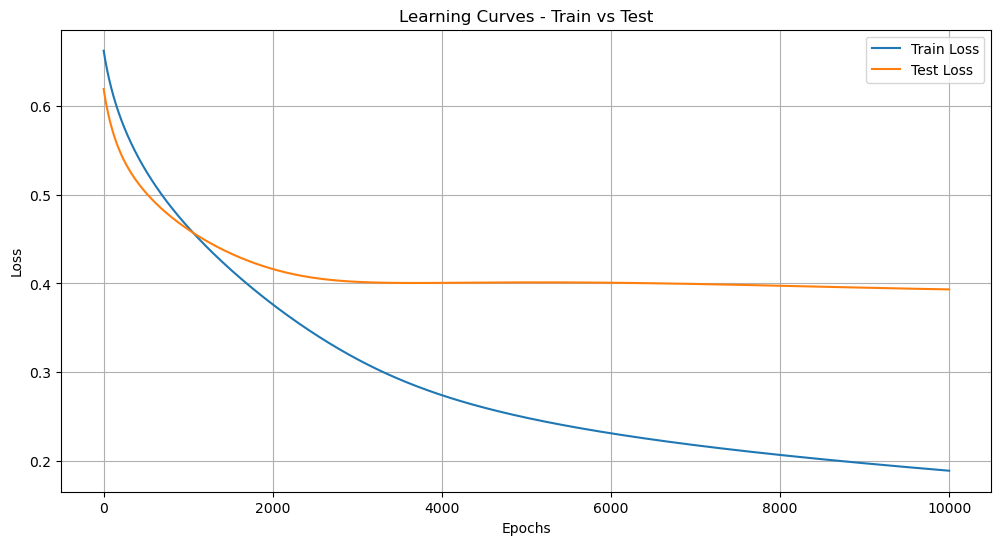

BCE loss for Train Data: 0.18885193923297552
BCE loss for Test Data: 0.3932875087102036


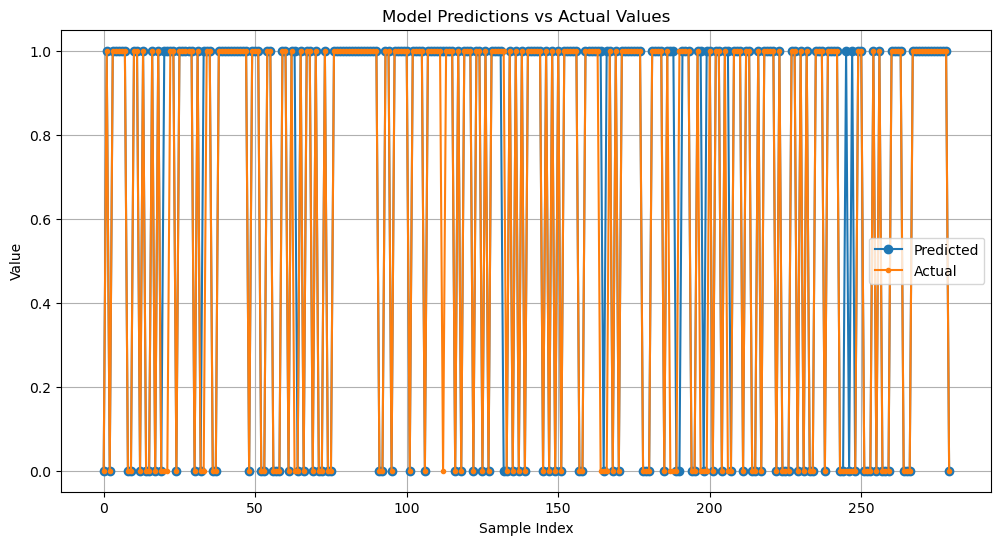

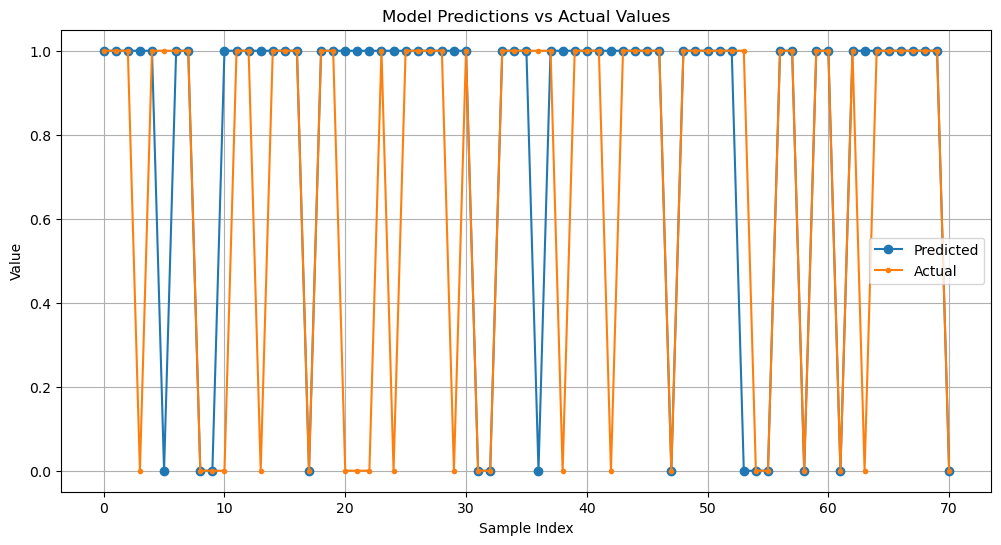

In [157]:
# Step 3 (Solution 2): Training model, Learning curve, and Train / Test Loss (BCE with L2 Regularization)

# Network Architecture
index_run = "Solution_2"

# Number of layers
L = len(layer_dims)

# Training model
weights, biases, latent_features, train_losses, test_losses = train(
    X_train, 
    Y_train, 
    layer_dims, 
    epoches, 
    learning_rate, 
    X_test, 
    Y_test, 
    seed=5,
    lambda_val=lambda_val
)
save_parameters(weights, biases, index_run)

# Visualizing learning curve for both training and test losses
visualize_learning_curve(train_losses, test_losses)

# Forward propagation to get predictions for training and test sets
_, A_train = forward_propagation(X_train, weights, biases)
_, A_test = forward_propagation(X_test, weights, biases)

# Extract predictions from the last layer (output layer)
Y_pred_train = A_train[f"A{L-1}"]
Y_pred_test = A_test[f"A{L-1}"]

# Calculate BCE loss with L2 regularization for train and test sets
bce_train = binary_cross_entropy_loss(Y_train, Y_pred_train, weights, lambda_val)
bce_test = binary_cross_entropy_loss(Y_test, Y_pred_test, weights, lambda_val)

# Print BCE losses for training and test sets
print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

# Plot actual vs predicted values for train and test sets (with thresholding)
plot_actual_vs_predicted(Y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(Y_test, thresholds(Y_pred_test))


In [158]:
# Step 2 (Solution 3): Define necessary functions - L2 + Batching
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def initialize_weights(layer_dims, seed=None):
    weights = {}
    biases = {}

    # Setup seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Loop through the layers and initialize weights and biases using Xavier Initialization
    for i in range(1, len(layer_dims)):  # Start from layer 1 to layer_dims-1
        # Xavier initialization for weights
        weights[f"W{i}"] = np.random.randn(layer_dims[i-1], layer_dims[i]).astype(np.float64) * np.sqrt(1 / layer_dims[i-1])
        biases[f"b{i}"] = np.zeros((1, layer_dims[i]), dtype=np.float64)

    return weights, biases


def binary_cross_entropy_loss(y_true, y_pred, weights, lambda_val):
    epsilon = 1e-12  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip to prevent log(0)

    cross_entropy_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Applied L2 regularization
    l2 = (lambda_val / (2 * y_true.shape[0])) * sum([np.sum(np.square(W)) for W in weights.values()])

    # Binary cross-entropy loss with L2 regularization
    loss = cross_entropy_loss + l2

    return loss


# Sigmoid activation function
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Clip to avoid overflow errors
    return 1 / (1 + np.exp(-x))


# Sigmoid derivative (used in backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)  # Derivative of sigmoid

# Tanh activation function
def tanh(x):
    return np.tanh(x)

# Tanh derivative (used in backpropagation)
def tanh_derivative(x):
    return 1.0 - np.tanh(x) ** 2

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# ReLU derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def forward_propagation(X, weights, biases):
    Xi = X  # Input layer
    Z = {}
    A = {}
    L = len(weights)  # Number of layers

    for index in range(1, L + 1):  # Loop over layers from 1 to L
        W = weights[f"W{index}"]
        b = biases[f"b{index}"]
        Zi = np.dot(Xi, W) + b
        Z[f"Z{index}"] = Zi

        # Apply Sigmoid activation for the last layer, ReLU for hidden layers
        if index == L:
            Ai = sigmoid(Zi)
        else:
            Ai = tanh(Zi)
        A[f"A{index}"] = Ai
        Xi = Ai  # Output of current layer becomes input to the next layer

    return Z, A


def backward_propagation(X, Y, Z, A, weights, output_activation="sigmoid", hidden_activation="tanh"):
    m = X.shape[0]  # Number of examples
    gradients = {}
    L = len(weights)  # Number of layers with weights
    # Step 1: Initialize the derivative for the output layer
    A_last = A[f"A{L}"]  # The predicted output from the last layer

    if output_activation == "sigmoid":
        dA_last = A_last - Y  # Error at the output layer for sigmoid
    else:
        raise NotImplementedError("Currently supports sigmoid for the output layer only.")

    dA_next = dA_last

    # Step 2: Backpropagation through layers (from L to 1)
    for l in reversed(range(1, L + 1)):
        if l == L:  # For the output layer, use dA_last directly
            dZ = dA_last
        else:
            # For hidden layers, backpropagate the error
            if hidden_activation == "relu":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * relu_derivative(Z[f"Z{l}"])
            elif hidden_activation == "sigmoid":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * sigmoid_derivative(A[f"A{l}"])
            elif hidden_activation == "tanh":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * tanh_derivative(Z[f"Z{l}"])
            else:
                raise NotImplementedError(f"Unsupported activation function: {hidden_activation}")

        # Compute gradients for weights and biases
        A_prev = A[f"A{l-1}"] if l > 1 else X  # A_prev is the activation from the previous layer or input X
        gradients[f"dW{l}"] = np.dot(A_prev.T, dZ) / m  # Gradient of W
        gradients[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m  # Gradient of b

        # Store dA_next for the next iteration
        dA_next = dZ

    return gradients

def create_mini_batches(X, Y, batch_size):
    """
    Create mini-batches from the input data and labels.
    
    Parameters:
    - X: Features
    - Y: Labels
    - batch_size: Size of each mini-batch
    
    Returns:
    - mini_batches: A list of (X_batch, Y_batch) tuples
    """
    m = X.shape[0]
    mini_batches = []

    # Shuffle the data before splitting into batches
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation, :]
    Y_shuffled = Y[permutation]

    # Create mini-batches
    num_batches = m // batch_size
    for i in range(num_batches):
        X_batch = X_shuffled[i * batch_size:(i + 1) * batch_size, :]
        Y_batch = Y_shuffled[i * batch_size:(i + 1) * batch_size]
        mini_batches.append((X_batch, Y_batch))

    # Handle the last batch if there are remaining samples
    if m % batch_size != 0:
        X_batch = X_shuffled[num_batches * batch_size:, :]
        Y_batch = Y_shuffled[num_batches * batch_size:]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches

def update_parameters(weights, biases, gradients, learning_rate, lambda_val):
    L = len(weights)  # Number of layers

    # Update each layer's weights and biases with L2 regularization
    for l in range(1, L + 1):
        weights[f"W{l}"] -= learning_rate * (gradients[f"dW{l}"] + (lambda_val / weights[f"W{l}"].shape[0]) * weights[f"W{l}"])
        biases[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    return weights, biases


def save_parameters(weights, biases, index):
    file_path = "./Parameters"
    np.save(f"{file_path}/weights_{index}.npy", weights)
    np.save(f"{file_path}/biases_{index}.npy", biases)

def train(
        X, 
        Y, 
        layer_dims, 
        epoches, 
        learning_rate, 
        X_test, 
        Y_test, 
        batch_size,  # Batch size for mini-batch gradient descent
        seed = None,
        lambda_val = 0.01
    ):
    weights = {}
    biases = {}
    train_losses = []
    test_losses = []
    latent_features = []
    step = int(epoches / 2) # Gather just two stages

    # Initialize weights and biases
    weights, biases = initialize_weights(layer_dims, seed)
    save_parameters(weights, biases, "initialize")

    # Number of layers
    L = len(layer_dims)

    # Training loop
    for epoch in range(epoches):
        # Create mini-batches
        mini_batches = create_mini_batches(X, Y, batch_size)

        for X_batch, Y_batch in mini_batches:
            # Forward propagation for each mini-batch
            Z, A = forward_propagation(X_batch, weights, biases)

            # Gather the latent features
            if epoch % step == 0:
                latent_features.append(A[f"A{L-2}"])

            # Calculate training loss with L2 regularization
            train_loss = binary_cross_entropy_loss(Y_batch, A[f"A{len(layer_dims) - 1}"], weights, lambda_val)
            train_losses.append(train_loss)

            # Backward propagation
            gradients = backward_propagation(X_batch, Y_batch, Z, A, weights, "sigmoid", "tanh")

            # Update parameters with L2 regularization
            weights, biases = update_parameters(weights, biases, gradients, learning_rate, lambda_val)
            # Test set forward propagation
            _, A_test = forward_propagation(X_test, weights, biases)

            # Calculate test loss with L2 regularization
            test_loss = binary_cross_entropy_loss(Y_test, A_test[f"A{len(layer_dims) - 1}"], weights, lambda_val)
            test_losses.append(test_loss)

            # Print epoch tracking every 500 epochs
            if epoch % 1000 == 0:
                print(f"Epoch {epoch+1}/{epoches}, Train Loss: {train_loss}, Test Loss: {test_loss}")



    return weights, biases, latent_features, train_losses, test_losses


# Visualization Functions

def visualize_learning_curve(train_losses, test_losses):
    # Visualize the learning curves for both train and test data together
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Learning Curves - Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()  # Show legend to differentiate between train and test curves
    plt.grid(True)
    plt.show()

def plot_actual_vs_predicted(actual, predicted, title="Actual vs Predicted"):
    # Visualize the predicted values against actual values (test data)
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label="Predicted", linestyle='-', marker='o')
    plt.plot(actual, label="Actual", linestyle='-', marker='.')
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def thresholds(data):
    data = np.where(data < 0.5, 0, 1)
    return data



Epoch 1/10000, Train Loss: 0.6992420014366314, Test Loss: 0.6191408234733194
Epoch 1/10000, Train Loss: 0.6655591571309359, Test Loss: 0.6182143246557004
Epoch 1/10000, Train Loss: 0.7681796646727785, Test Loss: 0.6176269248138138
Epoch 1/10000, Train Loss: 0.6841034650860691, Test Loss: 0.6169338625612547
Epoch 1/10000, Train Loss: 0.6337192198390187, Test Loss: 0.6163155411765693
Epoch 1/10000, Train Loss: 0.7603707280468449, Test Loss: 0.616388709547242
Epoch 1/10000, Train Loss: 0.5778498662850041, Test Loss: 0.6157655250346973
Epoch 1/10000, Train Loss: 0.5267178775938021, Test Loss: 0.6150422857371056
Epoch 1/10000, Train Loss: 0.6599547725993011, Test Loss: 0.6142382557430881
Epoch 1001/10000, Train Loss: 0.22100945179725653, Test Loss: 0.3948108918392428
Epoch 1001/10000, Train Loss: 0.22992156270608866, Test Loss: 0.3947771788863287
Epoch 1001/10000, Train Loss: 0.19224281255861966, Test Loss: 0.3947132579174537
Epoch 1001/10000, Train Loss: 0.1801380002965947, Test Loss: 0.39

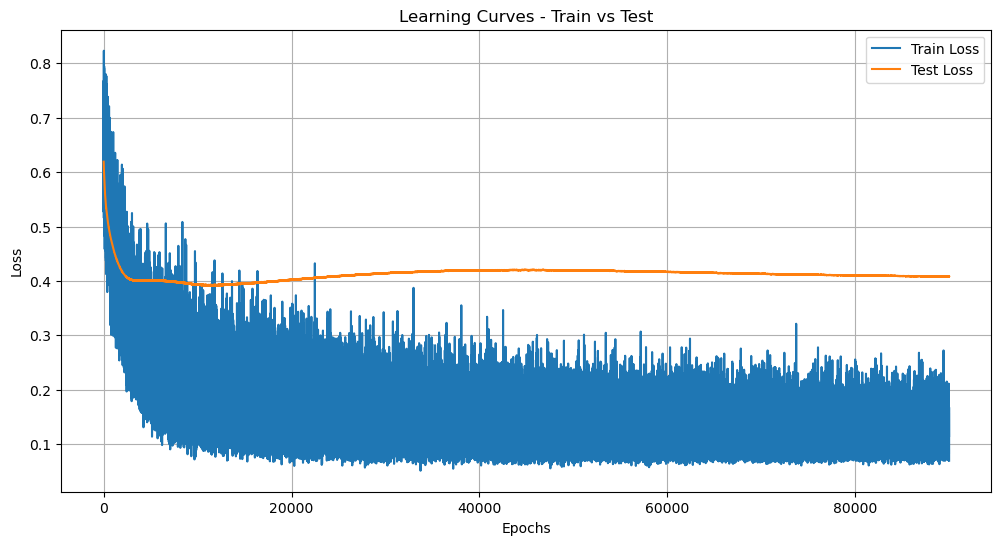

90000
90000
BCE loss for Train Data: 0.08492908493614301
BCE loss for Test Data: 0.4081531082255131


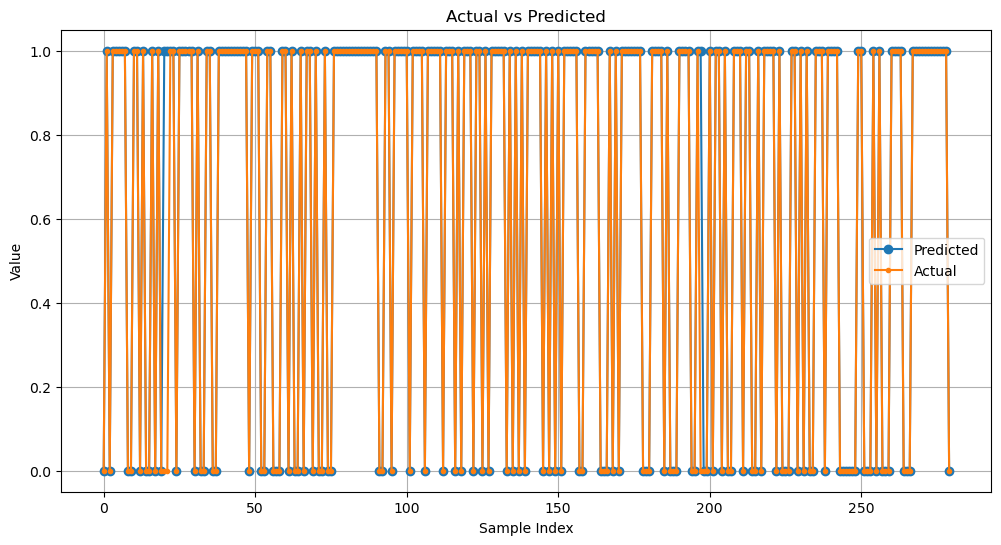

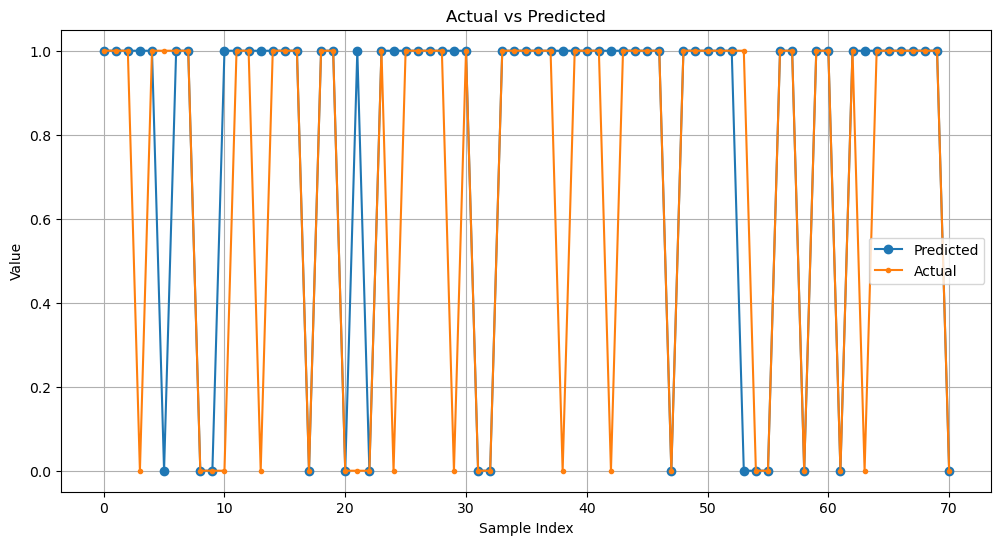

In [159]:
# Step 3 (Solution 3): Training model, Learning curve, and Train / Test Loss (BCE with L2 Regularization)

# Network Architecture
index_run = "Solution_23"
batch_size = 32  # Using mini-batch gradient descent
# Number of layers
L = len(layer_dims)

# Training model
weights, biases, latent_features, train_losses, test_losses = train(
    X_train, 
    Y_train, 
    layer_dims, 
    epoches, 
    learning_rate, 
    X_test, 
    Y_test, 
    batch_size,  # Batch size for mini-batch gradient descent
    seed=5,  # Random seed for reproducibility
    lambda_val=lambda_val  # L2 regularization strength
)

# Save trained parameters for later use
save_parameters(weights, biases, index_run)

# Visualizing learning curve for both training and test losses
visualize_learning_curve(train_losses, test_losses)

print(len(train_losses))
print(len(test_losses))

# Forward propagation to get predictions for training and test sets
_, A_train = forward_propagation(X_train, weights, biases)
_, A_test = forward_propagation(X_test, weights, biases)

# Extract predictions from the last layer (output layer)
Y_pred_train = A_train[f"A{L-1}"]
Y_pred_test = A_test[f"A{L-1}"]

# Calculate BCE loss with L2 regularization for train and test sets
bce_train = binary_cross_entropy_loss(Y_train, Y_pred_train, weights, lambda_val)
bce_test = binary_cross_entropy_loss(Y_test, Y_pred_test, weights, lambda_val)

# Print BCE losses for training and test sets
print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

# Plot actual vs predicted values for train and test sets (with thresholding)
plot_actual_vs_predicted(Y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(Y_test, thresholds(Y_pred_test))
